# Analyzing lifelogs from March 6-9 2018
Natalia Vélez, December 2019--January 2020


In [1]:
%matplotlib inline

import os, re, glob, random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from tqdm import tqdm_notebook
from ast import literal_eval as make_tuple

sns.set_context('paper')

Helper functions:

In [2]:
gsearch = lambda *args: glob.glob(opj(*args))
str_extract = lambda pattern, s: re.search(pattern, s).group(0)

## Load data

Find data files:

In [3]:
data_dir = '../data/'
data_files = gsearch(data_dir, 'publicLifeLogData', '**', '2018_03March_0*.txt')
data_files.sort()
print('%i files found' % len(data_files))
print(*[os.path.basename(f) for f in data_files], sep='\n')

40 files found
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_06_Tuesday.txt
2018_03March_07_Wednesday.txt
2018_03March_08_Thursday.txt
2018_03March_09_Friday.txt
2018_03March_07_Wednesday

Load all files:

In [4]:
data_list = []
empty_files = []
for f in tqdm_notebook(data_files):
    try:
        tmp_server = str_extract('(?<=lifeLog_)[a-zA-Z0-9]+', f)
        tmp_d = pd.read_csv(f, sep =' ', header=None)
        tmp_d.insert(0, 'server', tmp_server)
        data_list.append(tmp_d)
    except:
        empty_files.append(f)

In [5]:
raw_data = pd.concat(data_list)
raw_data.head()

,server,0,1,2,3,4,5,6,7,8
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,F,"(-49,607)",noParent,pop=1,chain=1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,M,"(-49,607)",parent=36490,pop=2,chain=2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,F,"(-70,74)",noParent,pop=3,chain=1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,M,"(-70,74)",parent=36492,pop=4,chain=2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,F,"(-37,95)",noParent,pop=5,chain=1


Deaths:

In [6]:
death_raw = raw_data[raw_data.iloc[:,1] == 'D'].copy().reset_index(drop=True)
death_raw.head()

,server,0,1,2,3,4,5,6,7,8
0,server1,D,1520559304,36496,ff3129a2dce20bda9df31ffcfcbfd3230977ea4e,age=14.34,F,"(67,36)",disconnect,pop=23
1,server1,D,1520559304,36497,14f418eedc7f854167ffb4ca5244ad95cee53f2a,age=0.31,F,"(67,36)",disconnect,pop=23
2,server1,D,1520559313,36499,ab7258ebd0ce2b381650386df6821220ac4783ca,age=0.40,M,"(-95,66)",hunger,pop=31
3,server1,D,1520559320,36503,74a504ee16b67a3c1f8649ac6f37543ffc072786,age=0.45,F,"(111,-16)",hunger,pop=32
4,server1,D,1520559321,36522,643ccc3f451b5b7cc46137e8e3f3ccb209fe83ff,age=14.16,F,"(19,-73)",disconnect,pop=32


Births:

In [7]:
birth_raw = raw_data[raw_data.iloc[:,1] == 'B'].copy().reset_index(drop=True)
birth_raw.head()

,server,0,1,2,3,4,5,6,7,8
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,F,"(-49,607)",noParent,pop=1,chain=1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,M,"(-49,607)",parent=36490,pop=2,chain=2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,F,"(-70,74)",noParent,pop=3,chain=1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,M,"(-70,74)",parent=36492,pop=4,chain=2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,F,"(-37,95)",noParent,pop=5,chain=1


Clean up data:

In [8]:
shared_header = ['server', 'event', 'timestamp', 'playerID', 'hash', 'age', 'sex',
                 'location', 'parent', 'cause_of_death', 'pop', 'chain']

In [9]:
death_data = death_raw.copy()
# Insert missing columns
death_data.insert(8, 'parent', np.nan)
death_data.insert(11, 'chain', np.nan)
death_data.columns = shared_header

for i, row in tqdm_notebook(death_data.iterrows(), total=death_data.shape[0]):
    age = str_extract('(?<=age=)\d+\.\d+', row['age'])
    age = float(age)
    
    pop = str_extract('(?<=pop=)[0-9]+', row['pop'])
    pop = int(pop)
    
    death_data.at[i, 'age'] = age
    death_data.at[i, 'pop'] = pop

death_data.head()

,server,event,timestamp,playerID,hash,age,sex,location,parent,cause_of_death,pop,chain
0,server1,D,1520559304,36496,ff3129a2dce20bda9df31ffcfcbfd3230977ea4e,14.34,F,"(67,36)",NaN,disconnect,23,NaN
1,server1,D,1520559304,36497,14f418eedc7f854167ffb4ca5244ad95cee53f2a,0.31,F,"(67,36)",NaN,disconnect,23,NaN
2,server1,D,1520559313,36499,ab7258ebd0ce2b381650386df6821220ac4783ca,0.4,M,"(-95,66)",NaN,hunger,31,NaN
3,server1,D,1520559320,36503,74a504ee16b67a3c1f8649ac6f37543ffc072786,0.45,F,"(111,-16)",NaN,hunger,32,NaN
4,server1,D,1520559321,36522,643ccc3f451b5b7cc46137e8e3f3ccb209fe83ff,14.16,F,"(19,-73)",NaN,disconnect,32,NaN


In [10]:
birth_data = birth_raw.copy()
# Insert missing columns
birth_data.insert(6, 'age', np.nan)
birth_data.insert(9, 'cause_of_death', np.nan)
birth_data.columns = shared_header

for i, row in tqdm_notebook(birth_data.iterrows(), total=birth_data.shape[0]):
    pop = str_extract('(?<=pop=)[0-9]+', row['pop'])
    pop = int(pop)
    
    chain = str_extract('(?<=chain=)[0-9]+', row['chain'])
    chain = int(chain)
    
    birth_data.at[i, 'pop'] = pop
    birth_data.at[i, 'chain'] = chain

birth_data.head()

,server,event,timestamp,playerID,hash,age,sex,location,parent,cause_of_death,pop,chain
0,server1,B,1520559275,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,F,NaN,"(-49,607)",noParent,NaN,1,1
1,server1,B,1520559278,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,M,NaN,"(-49,607)",parent=36490,NaN,2,2
2,server1,B,1520559278,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,F,NaN,"(-70,74)",noParent,NaN,3,1
3,server1,B,1520559279,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,M,NaN,"(-70,74)",parent=36492,NaN,4,2
4,server1,B,1520559280,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,F,NaN,"(-37,95)",noParent,NaN,5,1


Quick data check: Timestamps

In [17]:
birth_data.groupby('server').agg({'timestamp': ['min', 'max']})

timestamp            
                 min         max
server                          
server1   1520559275  1520639996
server10  1520321070  1520639970
server11  1520623876  1520627211
server12  1520627826  1520630827
server13  1520624058  1520637311
server14  1520628264  1520637910
server15  1520624759  1520639523
server2   1520294401  1520467198
server3   1520294406  1520467188
server4   1520294457  1520639996
server5   1520294493  1520553598
server6   1520294453  1520639994
server7   1520295474  1520639988
server8   1520384190  1520639983
server9   1520387414  1520639994

### Deaths: How and when do people die?

Age of death:

Plotting 79553 deaths


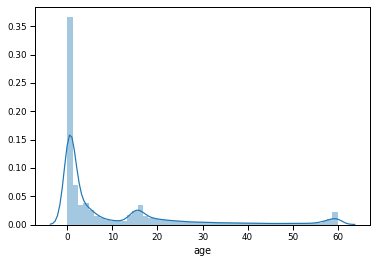

In [11]:
print('Plotting %i deaths' % len(death_data))
sns.distplot(death_data['age'])

Clean up cause of death:

In [12]:
death_causes = death_data.copy()
death_causes['cause_of_death'] = death_causes['cause_of_death'].str.replace("killer_[0-9]+", "murdered")

Frequency of causes of death:

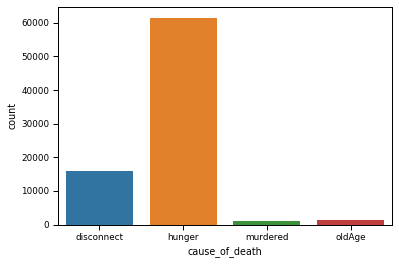

In [13]:
sns.countplot(x='cause_of_death', data=death_causes)

Age by cause of death:

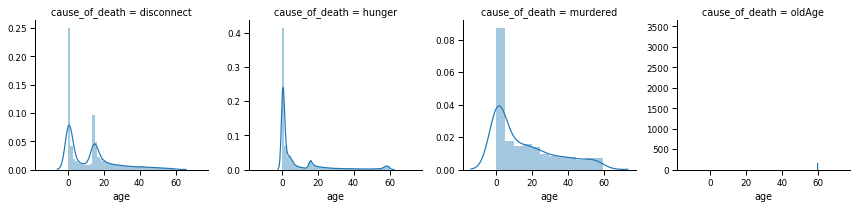

In [14]:
g = sns.FacetGrid(death_causes, col='cause_of_death', sharey=False)
g.map(sns.distplot, "age")

Location of deaths:

In [15]:
death_loc = death_causes.copy()
death_loc = death_loc[['timestamp', 'playerID', 'location', 'cause_of_death']]
death_loc['location'] = death_loc['location'].apply(make_tuple)
death_loc[['x', 'y']] = pd.DataFrame(death_loc['location'].tolist(), index=death_loc.index)  
death_loc.head()

,timestamp,playerID,location,cause_of_death,x,y
0,1520559304,36496,"(67, 36)",disconnect,67,36
1,1520559304,36497,"(67, 36)",disconnect,67,36
2,1520559313,36499,"(-95, 66)",hunger,-95,66
3,1520559320,36503,"(111, -16)",hunger,111,-16
4,1520559321,36522,"(19, -73)",disconnect,19,-73


<Figure size 2160x2160 with 0 Axes>

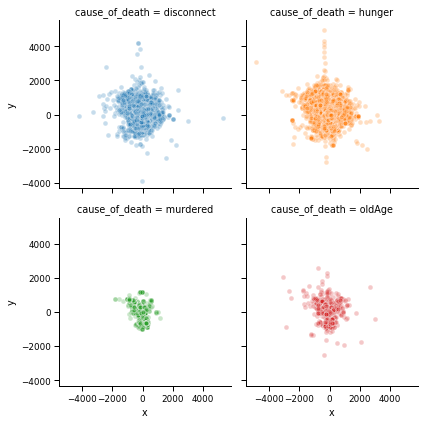

In [16]:
plt.figure(figsize=(30,30))
g = sns.FacetGrid(death_loc, col='cause_of_death', col_wrap=2, hue='cause_of_death')
g.map(sns.scatterplot, 'x', 'y', alpha=0.25)

## Migration: How far do people die from their place of birth?

Match births and deaths:

In [30]:
birth_loc = birth_data[['server', 'playerID', 'hash', 'location']]
birth_loc = birth_loc.rename(columns={'location': 'birth'})
birth_loc.head()

,server,playerID,hash,birth
0,server1,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,"(-49,607)"
1,server1,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,"(-49,607)"
2,server1,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,"(-70,74)"
3,server1,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,"(-70,74)"
4,server1,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,"(-37,95)"


In [38]:
death_loc = death_data[['server', 'playerID', 'hash', 'age', 'location']]
death_loc = death_loc.rename(columns={'location': 'death'})
death_loc.head()

,server,playerID,hash,age,death
0,server1,36496,ff3129a2dce20bda9df31ffcfcbfd3230977ea4e,14.34,"(67,36)"
1,server1,36497,14f418eedc7f854167ffb4ca5244ad95cee53f2a,0.31,"(67,36)"
2,server1,36499,ab7258ebd0ce2b381650386df6821220ac4783ca,0.4,"(-95,66)"
3,server1,36503,74a504ee16b67a3c1f8649ac6f37543ffc072786,0.45,"(111,-16)"
4,server1,36522,643ccc3f451b5b7cc46137e8e3f3ccb209fe83ff,14.16,"(19,-73)"


Distance:

In [65]:
dist_fun = lambda row: np.linalg.norm(row['death']-row['birth'])

life_loc =  birth_loc.merge(death_loc)
life_loc['age'] = life_loc['age'].astype(np.float)
life_loc['birth'] = life_loc['birth'].apply(make_tuple)
life_loc['birth'] = life_loc['birth'].apply(np.array)

life_loc['death'] = life_loc['death'].apply(make_tuple)
life_loc['death'] = life_loc['death'].apply(np.array)

life_loc['distance'] = life_loc.apply(dist_fun, axis=1)

life_loc.head()

,server,playerID,hash,birth,age,death,distance
0,server1,36490,49483e9224e4ccdb5af274bb71bb1e3de9aeedea,"[-49, 607]",25.22,"[-70, 686]",81.743501
1,server1,36491,50edfe49ea709e8764321ae12643c19ebf172c5f,"[-49, 607]",8.56,"[-99, 609]",50.039984
2,server1,36492,f402d6ab9f88bfe764c9cac07c75f1e39c8bb23c,"[-70, 74]",53.04,"[347, -55]",436.497423
3,server1,36493,26541162d8aeb20f1c633000ade50cabc23df1c5,"[-70, 74]",19.52,"[-43, 320]",247.477272
4,server1,36494,f623c5fbea396330c89487a06c5613b6cf80f65e,"[-37, 95]",17.22,"[-63, 69]",36.769553


19.209372712298546

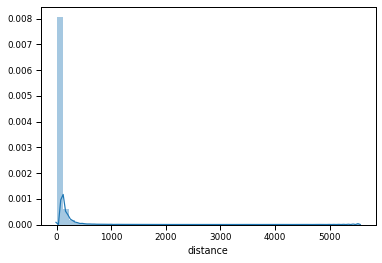

In [66]:
sns.distplot(life_loc['distance'])
np.median(life_loc['distance'])

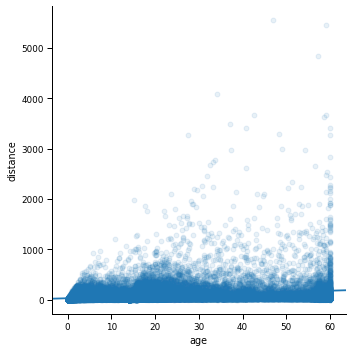

In [70]:
sns.lmplot(x="age", y="distance", data=life_loc, scatter_kws={'alpha': 0.1})

## Births: Charting family trees

### Prepare data

In [84]:
graph_data = birth_data[['playerID', 'parent']].copy()
graph_data = graph_data.rename(columns={"playerID": "child"})
graph_data['child'] = graph_data['child'].astype(np.float)
graph_data['parent'] = np.where(graph_data['parent'] == 'noParent', 
                                np.nan,
                                graph_data['parent'].str.replace('parent=', ''))
graph_data['parent'] = graph_data['parent'].astype(np.float)
graph_data.head()

,child,parent
0,36490.0,NaN
1,36491.0,36490.0
2,36492.0,NaN
3,36493.0,36492.0
4,36494.0,NaN


#### Data quality checks

How many nodes?

In [85]:
graph_data.nunique()

child     35446
parent    14171
dtype: int64

Are the entries in "children" a subset of "parent"?

In [88]:
children = graph_data['child'].unique()
parents = graph_data['parent'].unique()
parents = parents[~np.isnan(parents)]

In [89]:
np.all([p in children for p in parents])

True

Draw graph:

In [90]:
family_graph = nx.from_pandas_edgelist(graph_data, source='parent', target='child')

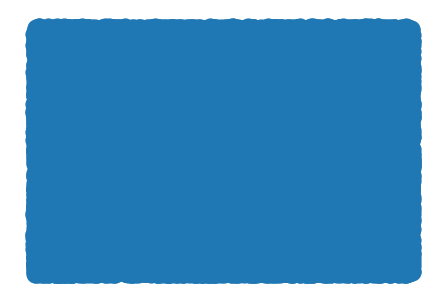

In [93]:
nx.draw_random(family_graph, with_labels=False)